In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore as zscore
from tqdm import tqdm
import math
from scipy.interpolate import CubicSpline
from scipy.signal import butter
from scipy import signal
import scipy
from scipy.stats import zscore as zscore



df = pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\Nishchay\Nishchay\monocular_data_1.csv") 
df1= pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\Nishchay\Nishchay\N_1_visuospatial_2023-06-22_19h09.08.015.csv") 
df2= pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\Nishchay\Nishchay\feedback_1.csv")
df3 = pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\Nishchay\Nishchay\blinks_1.csv")
len_data = df.shape[0]
len_blinks = df3.shape[0]
len_visuo = df1.shape[0]

In [2]:
trial=[]
df4=pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\Nishchay\Nishchay\trial_1.csv")
for i in range(0,60):
    trial.append(df4['0'][i])
    #trial.append(df4['0'][i]+df4['0'][i+1]+df4['0'][i+2])
    #i=i+3


In [3]:
trial

[1,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [4]:
def get_original_time(df,df1):
    
    i = 3
    k = 1
    original_time = []
    while i in range(3,59):
        if(i==60 or (i-60)%61==0):
            i = i+1
        
        start=df1["polygon.started"].iloc[i]
        end=df1["image.stopped"].iloc[i+3]

        block=[]
        block_time=[]
        for j in range(0,df.shape[0]):
            if(df["time"].iloc[j]>start and df["time"].iloc[j]<end):
                block.append(df["pupil_measure2"].iloc[j])
                block_time.append(df["time"].iloc[j])

            if(df["time"].iloc[j]>end):
                
                break    


        original_time.append(block_time)

        i = i+3
        
    return original_time
    

In [5]:
def drop_blink_data(df,df3):
    
    times = df["device_time"]
    times = times.to_numpy()
    
    for i in tqdm(range(len_blinks)):
        start = df3["start_timestamp"].iloc[i]
        end = df3["end_timestamp"].iloc[i]

        for j in range(len_data):

            time = times[j]

            if(time>start and time<end):
                df = df.drop(j)
    return df

In [6]:
def get_blinks_to_be_removed(df,df1):
    post_blinks_array = []
    i = 3
    k = 1
    missed_trials = []
    while i in range(3,59):


        if(i==60 or (i-60)%61==0):
            i = i+1

        start=df1["polygon.started"].iloc[i]
        end=df1["image.stopped"].iloc[i+3]


        block = []

        for j in range(0,df.shape[0]):
            if(df["time"].iloc[j]>=start and df["time"].iloc[j]<=end): 

                block.append(df["pupil_measure2"].iloc[j])

            elif(df["time"].iloc[j]>end):
                break

        if(len(block)!=0):
            post_blinks_array.append(block) 

        else:
            missed_trials.append(i)

        i = i+3
        
    trials_to_be_removed = []
    for i in range(len(post_blinks_array)):
            
        if(len(post_blinks_array[i])<400):
            trials_to_be_removed.append(i)
        
    return trials_to_be_removed,missed_trials
        

In [7]:
def get_fixation(df,df1):
    array_fixation=[]
    k = 0
    i = 3
    while i in range(3,59):

        if(i==60 or (i-60)%61==0):
            i = i+1

        start_1= df1["polygon.started"].iloc[i]
        end_1= df1["polygon.stopped"].iloc[i]
        start_2= df1["polygon.started"].iloc[i+1]
        end_2= df1["polygon.stopped"].iloc[i+1]
        start_3= df1["polygon.started"].iloc[i+2]
        end_3= df1["polygon.stopped"].iloc[i+2]


        temp_1 = []
        temp_2 = []
        temp_3 = []

        block=[]
        block_time=[]


        for j in range(0,df.shape[0]):
            if(df["time"].iloc[j]>start_1 and df["time"].iloc[j]<end_1): 
                temp_1.append(df["pupil_measure2"].iloc[j])


            if(df["time"].iloc[j]>start_2 and df["time"].iloc[j]<end_2): 
                temp_2.append(df["pupil_measure2"].iloc[j])


            if(df["time"].iloc[j]>start_3 and df["time"].iloc[j]<end_3): 
                temp_3.append(df["pupil_measure2"].iloc[j])


            if(df["time"].iloc[j]>end_3):
                break

        L = max(max(len(temp_1),len(temp_2)),len(temp_3))

        if(L == len(temp_1)):
            block.append(temp_1)

        elif(L == len(temp_2)):
            block.append(temp_2)

        else:
            block.append(temp_3)

        
        array_fixation.append(block)

        i = i+3
        
    mean_array = []

            
    for i in range(len(array_fixation)):
            
        if(len(array_fixation[i][0])<40):
            mean = np.mean(array_fixation[i][0])
            mean_array.append(mean)

        else:
            sliced_arr = array_fixation[i][0][13:len(array_fixation[i][0])-12]
            mean = np.mean(sliced_arr)
            mean_array.append(mean)
            

    return mean_array
    
        

In [8]:
def get_trials(df,df1,df2,mean_array,trials_to_be_removed,missed_trials,original_time):
    response = df2["0"].tolist()
    array_corr_high=[]
    array_corr_low=[]
    array_incor=[]
    len_array_corr_high=[]
    len_array_corr_low=[]
    len_array_incor=[]
    time=[]
    k=0
    i = 3
    while i in range(3,59):

        if(i==60 or (i-60)%61==0):
            i = i+1

        start=df1["polygon.started"].iloc[i]
        end=df1["image.stopped"].iloc[i+3]

        block=[]
        block_time=[]

        for j in range(0,df.shape[0]):
            if(df["time"].iloc[j]>start and df["time"].iloc[j]<end):
                block.append(df["pupil_measure2"].iloc[j])
                block_time.append(df["time"].iloc[j])

            if(df["time"].iloc[j]>end):
                break
        
        if(len(block)!=0):

            if(response[k]=="Correct"):

                if(k not in trials_to_be_removed and i not in missed_trials):
                    if(math.isnan(mean_array[k])==False):
                        if(trial[k]>1):                            
                            cs = CubicSpline(block_time, block)
                            xs = original_time[k]
                            array_corr_high.append(cs(xs)/mean_array[k])
                            len_array_corr_high.append(len(block))
                            
                        else:
                            cs = CubicSpline(block_time, block)
                            xs = original_time[k]
                            array_corr_low.append(cs(xs)/mean_array[k])
                            len_array_corr_low.append(len(block))


            else:

                if(k not in trials_to_be_removed and i not in missed_trials):
                    if(math.isnan(mean_array[k])==False):
                        cs = CubicSpline(block_time, block)
                        xs = original_time[k]
                        array_incor.append(cs(xs)/mean_array[k])
                        len_array_incor.append(len(block))  


            time.append(block_time)


        k=k+1 
        i = i+3
        
        
    return array_corr_high,array_corr_low,array_incor


In [9]:
def pipeline(df,df1,df2,df3):
    original_time = get_original_time(df,df1)
    df = drop_blink_data(df,df3)
    trials_to_be_removed,missed_trials = get_blinks_to_be_removed(df,df1)
    mean_array = get_fixation(df,df1)
    print(len(mean_array),len(trials_to_be_removed),len(missed_trials))
    array_corr_high,array_corr_low,array_incorr = get_trials(df,df1,df2,mean_array,trials_to_be_removed,missed_trials,original_time)
    
    return array_corr_high,array_corr_low,array_incorr,mean_array,trials_to_be_removed

In [10]:
array_corr_high,array_corr_low,array_incorr,mean_array,trials_to_be_removed = pipeline(df,df1,df2,df3)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.96it/s]
C:\Users\91901\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\91901\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


19 1 0


In [11]:
for i in range(len(mean_array)):
    if(math.isnan(mean_array[i])):
            print(i)

0


In [12]:
trials_to_be_removed

[5]

In [13]:
for i in range(len(array_corr_high)):
    array_corr_high[i] = array_corr_high[i].tolist()
for i in range(len(array_corr_low)):
    array_corr_low[i] = array_corr_low[i].tolist()

In [14]:
for i in range(len(array_incorr)):
    array_incorr[i] = array_incorr[i].tolist()

In [15]:
from scipy.signal import firwin, convolve

def apply_lowpass_filter(data, cutoff_freq, fs, numtaps=1001):
    # Calculate the filter coefficients using the FIR window method
    nyq_freq = fs / 2.0
    cutoff_norm = cutoff_freq / nyq_freq
    b = firwin(numtaps, cutoff_norm, window='hamming')
    
    # Apply the filter to the data
    filtered_data = convolve(data, b, mode='same')
    return filtered_data

def filtering(filter_type, res_array, order,wn):
    required_list = []
    if(filter_type=='bp'):
        x,y = butter(order, wn,fs = 120, btype=filter_type, analog=False) #change to 120 for monocular data
    elif (filter_type=='lp'):
#         for i in res_array:
#             required_list.append(apply_lowpass_filter(i,50,200))
            
#         return required_list
        x,y = butter(order, wn, btype=filter_type, analog=False)
    else:
        x,y = butter(order, wn, btype=filter_type, analog=False)
    
    high_freq_noise = []
    for i in range(len(res_array)): 
        res = scipy.signal.filtfilt(x,y,res_array[i],axis = 0)
        high_freq_noise.append(res_array[i]-res)
        required_list.append(res)
        
    return required_list,high_freq_noise

In [16]:
def z_scoring(required_list):
    new_list = []
    
    for i in range (len(required_list)):
        new_list.append(zscore(required_list[i]))
        
    return new_list

In [17]:
def length_array(new_list):
    length_array1 = []
    for i in range(len(new_list)):
        length_array1.append(len(new_list[i]))
    return length_array1

In [18]:
def mean(new_list,length_array1):
    list_weight_corr=[]
    
    new_list_temp = []
    for i in range(len(new_list)):
        new_list_temp.append(new_list[i])
    
    for i in range(0,len(new_list_temp)):
        array=np.zeros(max(length_array1))
        list_weight_corr.append(array) 
    
    
    
    
    for i in range(0,len(new_list_temp)):   
        l=max(length_array1)
    
        for j in range(0,len(new_list_temp[i])):
            (list_weight_corr[i])[j]=1
        new_list_temp[i]=np.pad(new_list_temp[i], (0,l-(len(new_list_temp[i])%l)),"constant") 
        
#     print(max(length_array1),len(new_list))
#     for i in range(0,max(length_array1)):
#         for j in range(len(new_list)):
#              print(new_list_temp[j][i])
    
    mean_array_corr=[]  
    for i in range(0,max(length_array1)):    
        mean=0
        weight=0
        for j in range(0,len(new_list)):
            weight= weight+list_weight_corr[j][i]            
            mean+=new_list_temp[j][i]
        mean_array_corr.append(mean/weight)
        
    return mean_array_corr

In [19]:
def padding(arr_mean):
    list_l=[]
    for i in arr_mean:
        list_l.append(len(i))
    l = max(list_l)
    arr_mean_padd=[]
    for i in arr_mean:
        arr_mean_padd.append(np.pad(i, (0,l-(len(i)%l)),"constant") )
        
    return l, arr_mean_padd

In [20]:
def weighted_mean_participants(l, arr_mean_padd):
    
    weights=[]
    for i in range(0,len(arr_mean_padd)):
        weight=np.zeros(l)
        for j in range(0,l):
            if(arr_mean_padd[i][j]!=0):
                weight[j]=1
        weights.append(weight)
    final=[]
    for i in range(0,l):
        mean=0
        weight=0
        for j in range(0,len(arr_mean_padd)):
            mean= mean+ arr_mean_padd[j][i]
            weight=weight + weights[j][i]
        final.append(mean/weight)
        
    return final

In [21]:
def remove_outliers(array):
    # Calculate the mean and standard deviation
    new_arr = []
    for arr in array:
        mean = np.mean(arr)
        std = np.std(arr)

        # Calculate the upper and lower bounds
        upper_bound = mean + (3 * std)
        lower_bound = mean - (3* std)

        # Remove elements outside the bounds
        
        arr = [x for x in arr if lower_bound <= x <= upper_bound]
        new_arr.append(arr)
        

    return new_arr

In [22]:
x1_corr,high_freq_noise_lp = filtering('lp',array_corr_high,5,0.2)
x2_corr,high_freq_noise_hp = filtering('hp',array_corr_high,2,0.9)
x3_corr,high_freq_noise_bp = filtering('bp',array_corr_high,2,[0.025,4])

x1_corr = remove_outliers(x1_corr)
x2_corr = remove_outliers(x2_corr)
x3_corr = remove_outliers(x3_corr)
x4_corr = remove_outliers(array_corr_high)

z1_corr = z_scoring(x1_corr)
z2_corr = z_scoring(x2_corr)
z3_corr = z_scoring(x3_corr)
z4_corr = z_scoring(x4_corr)

l1_corr = length_array(z1_corr)
l2_corr = length_array(z2_corr)
l3_corr = length_array(z3_corr)

m1_corr = mean(z1_corr,l1_corr)
m2_corr = mean(z2_corr,l2_corr)
m3_corr = mean(z3_corr,l3_corr)
length_raw_data_corr = length_array(z4_corr)
mean_on_raw_data_corr = mean(z4_corr,length_raw_data_corr)

In [23]:
x3_corr_low,high_freq_noise = filtering('bp',array_corr_low,2,[0.025,4])
x3_corr_low = remove_outliers(x3_corr_low)
x4_corr_low = remove_outliers(array_corr_low)
z3_corr_low = z_scoring(x3_corr_low)
z4_corr_low = z_scoring(x4_corr_low)
l3_corr_low = length_array(z3_corr_low)
m3_corr_low = mean(z3_corr_low,l3_corr_low)
length_raw_data_corr_low = length_array(z4_corr_low)
mean_on_raw_data_corr_low = mean(z4_corr_low,length_raw_data_corr_low)


In [24]:
time_lp = np.arange(len(m1_corr)) * 0.008
time_hp = np.arange(len(m2_corr)) * 0.008
time_bp = np.arange(len(m3_corr_low)) * 0.008
time_raw = np.arange(len(mean_on_raw_data_corr_low)) * 0.008

In [25]:
from numpy import asarray
from numpy import savetxt

savetxt('data-Nishchay1-low.csv', mean_on_raw_data_corr_low, delimiter=',')
savetxt('data-filtered-Nishchay1-low.csv', m3_corr_low, delimiter=',')

savetxt('data-Nishchay1-high.csv', mean_on_raw_data_corr, delimiter=',')
savetxt('data-filtered-Nishchay1-high.csv', m3_corr, delimiter=',')

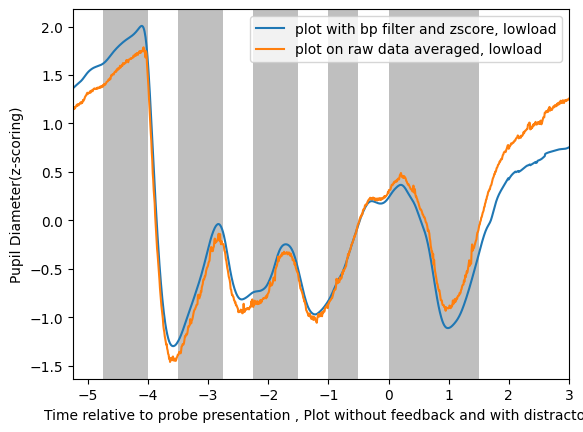

In [86]:
# plt.plot(time_lp-5,m1_corr, label='plot with lp filter and zscore')
# plt.plot(time_hp-5,m2_corr, label='plot with hp filter and zscore')
plt.plot(time_bp-5.25,m3_corr_low, label='plot with bp filter and zscore, lowload')
plt.plot(time_raw-5.25,mean_on_raw_data_corr_low, label = 'plot on raw data averaged, lowload')
plt.legend()
plt.xlim(-5.25,3)
plt.axvspan(-4.75,-4, facecolor ='0.5', alpha = 0.5) 
plt.axvspan(-3.5,-2.75, facecolor ='0.5', alpha = 0.5) 
plt.axvspan(-2.25,-1.5, facecolor ='0.5', alpha = 0.5) 
plt.axvspan(-1,-0.5, facecolor ='0.5', alpha = 0.5) 
plt.axvspan(-0,1.5, facecolor ='0.5', alpha = 0.5) 

plt.xlabel("Time relative to probe presentation , Plot without feedback and with distractors")
plt.ylabel("Pupil Diameter(z-scoring)")
plt.show()

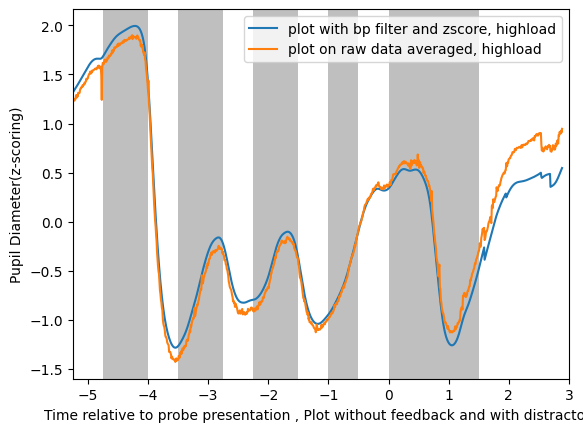

In [87]:
time_bp_h = np.arange(len(m3_corr)) * 0.008
time_raw_h = np.arange(len(mean_on_raw_data_corr)) * 0.008
plt.plot(time_bp_h-5.25,m3_corr, label='plot with bp filter and zscore, highload')
plt.plot(time_raw_h-5.25,mean_on_raw_data_corr, label = 'plot on raw data averaged, highload')
plt.legend()
plt.xlim(-5.25,3)
plt.axvspan(-4.75,-4, facecolor ='0.5', alpha = 0.5) 
plt.axvspan(-3.5,-2.75, facecolor ='0.5', alpha = 0.5) 
plt.axvspan(-2.25,-1.5, facecolor ='0.5', alpha = 0.5) 
plt.axvspan(-1,-0.5, facecolor ='0.5', alpha = 0.5) 
plt.axvspan(-0,1.5, facecolor ='0.5', alpha = 0.5) 

plt.xlabel("Time relative to probe presentation , Plot without feedback and with distractors")
plt.ylabel("Pupil Diameter(z-scoring)")
plt.show()

In [27]:
len(m3_corr_low)

1103

In [28]:
len(mean_on_raw_data_corr_low)

1103

In [29]:
x1_incorr,high_freq_noise_lp = filtering('lp',array_incorr,2,0.1) 
x2_incorr,high_freq_noise_bp = filtering('hp',array_incorr,2,0.9) 
x3_incorr,high_freq_noise_hp = filtering('bp',array_incorr,2,[0.025,4]) 

x1_incorr = remove_outliers(x1_incorr)
x2_incorr = remove_outliers(x2_incorr)
x3_incorr = remove_outliers(x3_incorr)
x4_incorr = remove_outliers(array_incorr)

z1_incorr = z_scoring(x1_incorr) 
z2_incorr = z_scoring(x2_incorr) 
z3_incorr = z_scoring(x3_incorr)
z4_incorr = z_scoring(x4_incorr)

l1_incorr = length_array(z1_incorr) 
l2_incorr = length_array(z2_incorr) 
l3_incorr = length_array(z3_incorr) 
m1_incorr = mean(z1_incorr,l1_incorr) 
m2_incorr = mean(z2_incorr,l2_incorr) 
m3_incorr = mean(z3_incorr,l3_incorr) 
length_raw_data_incorr = length_array(z4_incorr) 
mean_on_raw_data_incorr = mean(z4_incorr,length_raw_data_incorr)

ValueError: max() arg is an empty sequence

In [30]:
time_lp_incorr = np.arange(len(m1_incorr)) * 0.008
time_hp_incorr = np.arange(len(m2_incorr)) * 0.008
time_bp_incorr = np.arange(len(m3_incorr)) * 0.008
time_raw_incorr = np.arange(len(mean_on_raw_data_incorr)) * 0.008

NameError: name 'm1_incorr' is not defined

In [31]:
# plt.plot(time_lp_incorr-5,m1_incorr, label='plot with lp filter and zscore')
# plt.plot(time_hp_incorr-5,m2_incorr, label='plot with hp filter and zscore')
plt.plot(time_bp_incorr-5,m3_incorr, label='plot with bp filter and zscore')
plt.plot(time_raw_incorr-5,mean_on_raw_data_incorr, label = 'plot on raw data averaged')
plt.legend()
plt.xlim(-5,3)
plt.axvspan(-4.3, -3.5, facecolor ='0.5', alpha = 0.5) 
plt.axvspan(-3.1, -2.3, facecolor ='0.5', alpha = 0.5) 
plt.axvspan(-1.9, -0.8, facecolor ='0.5', alpha = 0.5) 
plt.axvspan(-0.3,1.4, facecolor ='0.5', alpha = 0.5) 
plt.xlabel("Time relative to probe presentation")
plt.ylabel("Pupil Diameter(z-scoring)")
plt.show()

NameError: name 'time_bp_incorr' is not defined

In [32]:
mean_array_corr_uf = []
mean_array_corr_f = []

In [1]:
#xx=pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-Nishchay8-low.csv")
#xx.iloc[:, 0].tolist()

In [34]:
mean_array_corr_high_uf=[]
mean_array_corr_low_uf=[]
mean_array_corr_high_f=[]
mean_array_corr_low_f=[]
dfUf_1_l= pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-Nishchay1-low.csv")
mean_array_corr_low_uf.append(dfUf_1_l.iloc[:, 0].tolist())
dfUf_2_l=pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-Nishchay2-low.csv")
mean_array_corr_low_uf.append(dfUf_2_l.iloc[:, 0].tolist())
dfUf_3_l=pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-Nishchay3-low.csv")
mean_array_corr_low_uf.append(dfUf_3_l.iloc[:, 0].tolist())
dfUf_4_l= pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-Nishchay4-low.csv")
mean_array_corr_low_uf.append(dfUf_4_l.iloc[:, 0].tolist())
dfUf_5_l=pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-Nishchay5-low.csv")
mean_array_corr_low_uf.append(dfUf_5_l.iloc[:, 0].tolist())
dfUf_6_l=pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-Nishchay6-low.csv")
mean_array_corr_low_uf.append(dfUf_6_l.iloc[:, 0].tolist())
dfUf_7_l= pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-Nishchay7-low.csv")
mean_array_corr_low_uf.append(dfUf_7_l.iloc[:, 0].tolist())
dfUf_8_l=pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-Nishchay8-low.csv")
mean_array_corr_low_uf.append(dfUf_8_l.iloc[:, 0].tolist())

dff_1_l= pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-filtered-Nishchay1-low.csv")
mean_array_corr_low_f.append(dff_1_l.iloc[:, 0].tolist())
dff_2_l=pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-filtered-Nishchay2-low.csv")
mean_array_corr_low_f.append(dfUf_2_l.iloc[:, 0].tolist())
dff_3_l=pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-filtered-Nishchay3-low.csv")
mean_array_corr_low_f.append(dfUf_3_l.iloc[:, 0].tolist())
dff_4_l= pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-filtered-Nishchay4-low.csv")
mean_array_corr_low_f.append(dfUf_4_l.iloc[:, 0].tolist())
dff_5_l=pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-filtered-Nishchay5-low.csv")
mean_array_corr_low_f.append(dfUf_5_l.iloc[:, 0].tolist())
dff_6_l=pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-filtered-Nishchay6-low.csv")
mean_array_corr_low_f.append(dfUf_6_l.iloc[:, 0].tolist())
dff_7_l= pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-filtered-Nishchay7-low.csv")
mean_array_corr_low_f.append(dfUf_7_l.iloc[:, 0].tolist())
dff_8_l=pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-filtered-Nishchay8-low.csv")
mean_array_corr_low_f.append(dfUf_8_l.iloc[:, 0].tolist())

In [40]:
dfUf_1_h= pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-Nishchay1-high.csv")
mean_array_corr_high_uf.append(dfUf_1_h.iloc[:, 0].tolist())
dfUf_2_h=pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-Nishchay2-high.csv")
mean_array_corr_high_uf.append(dfUf_2_h.iloc[:, 0].tolist())
dfUf_3_h=pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-Nishchay3-high.csv")
mean_array_corr_high_uf.append(dfUf_3_h.iloc[:, 0].tolist())
dfUf_4_h= pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-Nishchay4-high.csv")
mean_array_corr_high_uf.append(dfUf_4_h.iloc[:, 0].tolist())
dfUf_5_h=pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-Nishchay5-high.csv")
mean_array_corr_high_uf.append(dfUf_5_h.iloc[:, 0].tolist())
dfUf_6_h=pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-Nishchay6-high.csv")
mean_array_corr_high_uf.append(dfUf_6_h.iloc[:, 0].tolist())
dfUf_7_h= pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-Nishchay7-high.csv")
mean_array_corr_high_uf.append(dfUf_7_h.iloc[:, 0].tolist())
dfUf_8_h=pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-Nishchay8-high.csv")
mean_array_corr_high_uf.append(dfUf_8_h.iloc[:, 0].tolist())

dff_1_h= pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-filtered-Nishchay1-high.csv")
mean_array_corr_high_f.append(dff_1_h.iloc[:, 0].tolist())
dff_2_h=pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-filtered-Nishchay2-high.csv")
mean_array_corr_high_f.append(dfUf_2_h.iloc[:, 0].tolist())
dff_3_h=pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-filtered-Nishchay3-high.csv")
mean_array_corr_high_f.append(dfUf_3_h.iloc[:, 0].tolist())
dff_4_h= pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-filtered-Nishchay4-high.csv")
mean_array_corr_high_f.append(dfUf_4_h.iloc[:, 0].tolist())
dff_5_h=pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-filtered-Nishchay5-high.csv")
mean_array_corr_high_f.append(dfUf_5_h.iloc[:, 0].tolist())
dff_6_h=pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-filtered-Nishchay6-high.csv")
mean_array_corr_high_f.append(dfUf_6_h.iloc[:, 0].tolist())
dff_7_h= pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-filtered-Nishchay7-high.csv")
mean_array_corr_high_f.append(dfUf_7_h.iloc[:, 0].tolist())
dff_8_h=pd.read_csv(r"C:\Users\91901\Dropbox\PC\Downloads\data-filtered-Nishchay8-high.csv")
mean_array_corr_high_f.append(dfUf_8_h.iloc[:, 0].tolist())

In [83]:
length_low_uf = length_array(mean_array_corr_low_uf)
final_low_uf = mean(mean_array_corr_low_uf,length_low_uf)
length_high_uf = length_array(mean_array_corr_high_uf)
final_high_uf = mean(mean_array_corr_high_uf,length_high_uf)
length_low_f = length_array(mean_array_corr_low_f)
final_low_f = mean(mean_array_corr_low_f,length_low_f)
length_high_f = length_array(mean_array_corr_high_f)
final_high_f = mean(mean_array_corr_high_f,length_high_f)

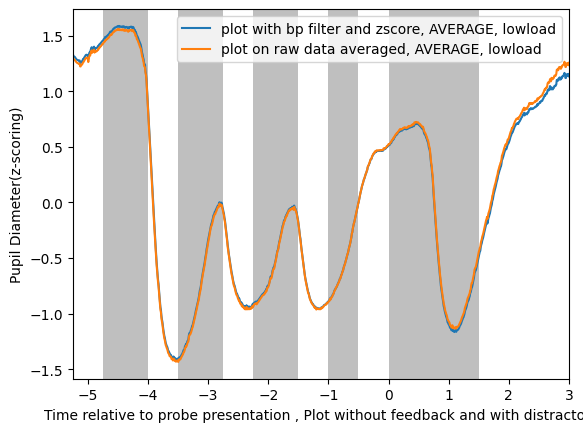

In [98]:
time_average_l=np.arange(len(final_low_f)) * 0.008
time_raw_average_l_f=np.arange(len(final_low_uf)) * 0.008
plt.plot(time_average_l-5.25,final_low_f, label='plot with bp filter and zscore, AVERAGE, lowload')
plt.plot(time_raw_average_l_f-5.25,final_low_uf, label = 'plot on raw data averaged, AVERAGE, lowload')
plt.legend()
plt.xlim(-5.25,3)
plt.axvspan(-4.75,-4, facecolor ='0.5', alpha = 0.5) 
plt.axvspan(-3.5,-2.75, facecolor ='0.5', alpha = 0.5) 
plt.axvspan(-2.25,-1.5, facecolor ='0.5', alpha = 0.5) 
plt.axvspan(-1,-0.5, facecolor ='0.5', alpha = 0.5) 
plt.axvspan(-0,1.5, facecolor ='0.5', alpha = 0.5) 

plt.xlabel("Time relative to probe presentation , Plot without feedback and with distractors")
plt.ylabel("Pupil Diameter(z-scoring)")
plt.show()

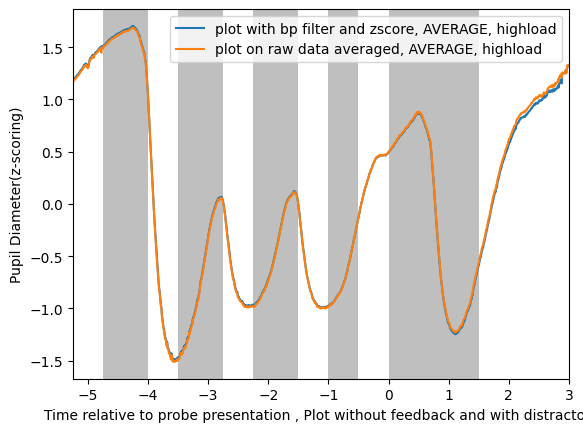

In [99]:
time_average_h=np.arange(len(final_high_f)) * 0.008
time_raw_average_h_f=np.arange(len(final_high_uf)) * 0.008
plt.plot(time_average_h-5.25,final_high_f, label='plot with bp filter and zscore, AVERAGE, highload')
plt.plot(time_raw_average_h_f-5.25,final_high_uf, label = 'plot on raw data averaged, AVERAGE, highload')
plt.legend()
plt.xlim(-5.25,3)
plt.axvspan(-4.75,-4, facecolor ='0.5', alpha = 0.5) 
plt.axvspan(-3.5,-2.75, facecolor ='0.5', alpha = 0.5) 
plt.axvspan(-2.25,-1.5, facecolor ='0.5', alpha = 0.5) 
plt.axvspan(-1,-0.5, facecolor ='0.5', alpha = 0.5) 
plt.axvspan(-0,1.5, facecolor ='0.5', alpha = 0.5) 

plt.xlabel("Time relative to probe presentation , Plot without feedback and with distractors")
plt.ylabel("Pupil Diameter(z-scoring)")
plt.show()

In [79]:
savetxt('Nishchay_average_low_uf.csv', final_low_uf, delimiter=',')
savetxt('Nishchay_average_high_uf.csv', final_high_uf, delimiter=',')
savetxt('Nishchay_average_low_f.csv', final_low_f, delimiter=',')
savetxt('Nishchay_average_high_f.csv', final_high_f, delimiter=',')

In [37]:
mean_low_uf=[pd.read_csv(r"C:\Users\USER\Downloads\Sejal_mean_low_uf.csv").iloc[:,0].tolist(),pd.read_csv(r"C:\Users\USER\Downloads\Rishit_mean_low_uf.csv").iloc[:,0].tolist(),pd.read_csv(r"C:\Users\USER\Downloads\Dolcy_mean_low_uf.csv").iloc[:,0].tolist(),pd.read_csv(r"C:\Users\USER\Downloads\Manasi_mean_low_uf.csv").iloc[:,0].tolist(),pd.read_csv(r"C:\Users\USER\Downloads\AG_mean_low_uf.csv").iloc[:,0].tolist()]
mean_low_f=[pd.read_csv(r"C:\Users\USER\Downloads\Sejal_mean_low_f.csv").iloc[:,0].tolist(),pd.read_csv(r"C:\Users\USER\Downloads\Rishit_mean_low_f.csv").iloc[:,0].tolist(),pd.read_csv(r"C:\Users\USER\Downloads\Dolcy_mean_low_f.csv").iloc[:,0].tolist(),pd.read_csv(r"C:\Users\USER\Downloads\Manasi_mean_low_f.csv").iloc[:,0].tolist(),pd.read_csv(r"C:\Users\USER\Downloads\AG_mean_low_f.csv").iloc[:,0].tolist()]
mean_high_uf=[pd.read_csv(r"C:\Users\USER\Downloads\Sejal_mean_high_f.csv").iloc[:,0].tolist(),pd.read_csv(r"C:\Users\USER\Downloads\Rishit_mean_high_f.csv").iloc[:,0].tolist(),pd.read_csv(r"C:\Users\USER\Downloads\Dolcy_mean_high_f.csv").iloc[:,0].tolist(),pd.read_csv(r"C:\Users\USER\Downloads\Manasi_mean_high_f.csv").iloc[:,0].tolist(),pd.read_csv(r"C:\Users\USER\Downloads\AG_mean_high_f.csv").iloc[:,0].tolist()]
mean_high_f=[pd.read_csv(r"C:\Users\USER\Downloads\Sejal_mean_high_f.csv").iloc[:,0].tolist(),pd.read_csv(r"C:\Users\USER\Downloads\Rishit_mean_high_f.csv").iloc[:,0].tolist(),pd.read_csv(r"C:\Users\USER\Downloads\Dolcy_mean_high_f.csv").iloc[:,0].tolist(),pd.read_csv(r"C:\Users\USER\Downloads\Manasi_mean_high_f.csv").iloc[:,0].tolist(),pd.read_csv(r"C:\Users\USER\Downloads\AG_mean_high_f.csv").iloc[:,0].tolist()]



mean_length_low_uf = length_array(mean_low_uf)
mean_final_low_uf = mean(mean_low_uf,length_low_uf)
mean_length_high_uf = length_array(mean_high_uf)
mean_final_high_uf = mean(mean_high_uf,length_high_uf)
mean_length_low_f = length_array(mean_low_f)
mean_final_low_f = mean(mean_low_f,length_low_f)
mean_length_high_f = length_array(mean_high_f)
mean_final_high_f = mean(mean_high_f,length_high_f)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\USER\\Downloads\\Sejal_mean_low_uf.csv'

In [38]:
time_final_l=np.arange(len(mean_length_low_uf)) * 0.008
time_final_l_f=np.arange(len(mean_length_low_f)) * 0.008
time_final_h=np.arange(len(mean_length_high_uf)) * 0.008
time_final_h_f=np.arange(len(mean_length_high_f)) * 0.008
plt.plot(time_final_h_f-5.25,mean_final_high_f, label = 'high-filtered ')
plt.plot(time_final_l-5.25,mean_final_low_uf, label = 'low-unfiltered')
plt.plot(time_final_l_f-5.25,mean_final_low_f, label = 'low-filtered ')
plt.plot(time_final_h-5.25,mean_final_high_uf, label = 'high-unfiltered')
plt.legend()
plt.xlim(-5.25,3)
plt.axvspan(-4.75,-4, facecolor ='0.5', alpha = 0.5) 
plt.axvspan(-3.5,-2.75, facecolor ='0.5', alpha = 0.5) 
plt.axvspan(-2.25,-1.5, facecolor ='0.5', alpha = 0.5) 
plt.axvspan(-1,-0.5, facecolor ='0.5', alpha = 0.5) 
plt.axvspan(-0,1.5, facecolor ='0.5', alpha = 0.5)  
plt.xlabel("Time relative to probe presentation | N=6")
plt.ylabel("Pupil Diameter(z-scoring)")

plt.savefig('_highlow_Plot.pdf')

NameError: name 'final_low_uf' is not defined

In [39]:
l, arr_mean_padd = padding(mean_array_corr)
final_1 = weighted_mean_participants(l, arr_mean_padd)
plt.plot(final, label = 'weighted mean of all partcipants')
# plt.plot(final_1, label = 'weighted mean of all partcipants')
plt.legend()
plt.title("Plot after taking weighted mean of the participants")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

NameError: name 'mean_array_corr' is not defined

NameError: name 'final' is not defined

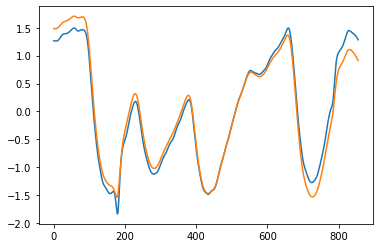

In [40]:
plt.plot(m1_incorr, label='plot with lp filter and zscore')
# plt.plot(m2, label='plot with hp filter and zscore')
plt.plot(m3_incorr, label='plot with bp filter and zscore')
plt.plot(final, label = 'plot on raw data averaged')
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [41]:
list1 = [1,2,3,4]

In [48]:
#list1/4

In [49]:
import pickle
picklefile = open('/Users/rahulsehgal/Downloads/Akshat_corr.sav','wb')
pickle.dump(array_corr, picklefile)
picklefile.close()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/rahulsehgal/Downloads/Akshat_corr.sav'

In [50]:
import pickle
picklefile = open('/Users/rahulsehgal/Downloads/Akshat_incorr.sav','wb')
pickle.dump(array_incorr, picklefile)
picklefile.close()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/rahulsehgal/Downloads/Akshat_incorr.sav'